В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv('./train.csv')

raw_df = raw_df.drop(columns=["Surname", "CustomerId", "id"])

input_cols = raw_df.columns.to_list()
input_cols[-1]

raw_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14995,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [4]:
train_df, val_df = split_train_val(raw_df, "Exited")

train_inputs, train_target = separate_inputs_targets(train_df, input_cols[:-1], input_cols[-1])
val_inputs, val_target = separate_inputs_targets(val_df, input_cols[:-1], input_cols[-1])


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [7]:
train_inputs[["Geography", "Gender"]] = train_inputs[["Geography", "Gender"]].astype("category")
val_inputs[["Geography", "Gender"]] = val_inputs[["Geography", "Gender"]].astype("category")

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [8]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=12,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(train_inputs, train_target)

train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

train_proba = xgb_clf.predict_proba(train_inputs)
val_proba = xgb_clf.predict_proba(val_inputs)


print(classification_report(train_target, train_pred, digits=4))
print(classification_report(val_target, val_pred, digits=4))

print(roc_auc_score(train_target, train_proba[:, -1]))
print(roc_auc_score(val_target, val_proba[:, -1]))


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:27:26] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0     0.9175    0.9609    0.9387      9558
         1.0     0.8121    0.6618    0.7292      2442

    accuracy                         0.9000     12000
   macro avg     0.8648    0.8113    0.8340     12000
weighted avg     0.8960    0.9000    0.8961     12000

              precision    recall  f1-score   support

         0.0     0.9176    0.9552    0.9360      2390
         1.0     0.7910    0.6639    0.7219       610

    accuracy                         0.8960      3000
   macro avg     0.8543    0.8096    0.8290      3000
weighted avg     0.8919    0.8960    0.8925      3000

0.9353910707488863
0.9344341175663626


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:27:26] WARNING: D:\bld\xgboost-split_1722296539223\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


This model has much better rocauc then all the previous models. The estiamtion is pretty good, i would say it has good bias/variance balance

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [6]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

def objective(params):
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        scale_pos_weight=params['scale_pos_weight'],
        max_delta_step=int(params['max_delta_step']),
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        eval_metric="auc",
        early_stopping_rounds=10,
        device="cuda"
    )

    clf.fit(
        train_inputs,
        train_target,
        eval_set=[(val_inputs, val_target)],
        verbose=False
    )
    pred = clf.predict_proba(val_inputs)
    
    accuracy = roc_auc_score(val_target, pred[:, -1])
    print("accuracy")
    print(accuracy)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['max_delta_step'] = int(best['max_delta_step'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    scale_pos_weight=best['scale_pos_weight'],
    max_delta_step=best['max_delta_step'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    eval_metric="auc",
    early_stopping_rounds=10,
    device="cuda"
)

final_clf.fit(
    train_inputs,
    train_target,
    eval_set=[(val_inputs, val_target)],
    verbose=False
)
final_pred = final_clf.predict_proba(val_inputs)
final_accuracy = roc_auc_score(val_target, final_pred[:, -1])
print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:53] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                              
0.9323108580835447                                    
accuracy                                                                         
0.9355943480348446                                                               
  4%|▍         | 2/50 [00:00<00:12,  3.99trial/s, best loss: -0.9355943480348446]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:53] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:54] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                         
0.9300192057068387                                                               
  6%|▌         | 3/50 [00:01<00:18,  2.57trial/s, best loss: -0.9355943480348446]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:54] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                         
0.9270776459290762                                                               
                                                                                 

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:54] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy
0.9321136566293984                                                               
accuracy                                                                         
0.9356886617737842                                                               
 12%|█▏        | 6/50 [00:01<00:10,  4.30trial/s, best loss: -0.9356886617737842]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:55] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:55] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                         
0.9361814939296249                                                               
 14%|█▍        | 7/50 [00:01<00:08,  4.81trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:55] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                         
0.9325769943068798                                                               
 16%|█▌        | 8/50 [00:02<00:08,  4.79trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:55] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                         
0.9304732834899513                                                               
accuracy                                                                         
0.9323876809108992                                                               
 20%|██        | 10/50 [00:02<00:08,  4.79trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:55] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9331260717470333                                                                
 22%|██▏       | 11/50 [00:02<00:07,  4.96trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:56] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:56] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9259386789217369                                                                
 24%|██▍       | 12/50 [00:03<00:10,  3.62trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:56] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9338795527813979                                                                
 26%|██▌       | 13/50 [00:03<00:09,  3.86trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:56] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9273228616503189                                                                
 28%|██▊       | 14/50 [00:03<00:09,  3.94trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:57] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9334275327525894                                                                
 30%|███       | 15/50 [00:03<00:10,  3.27trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:57] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.924051718224844                                                                 
 32%|███▏      | 16/50 [00:04<00:10,  3.27trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:57] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9322213457713149                                                                
accuracy                                                                          
0.9252740242815007                                                                
 36%|███▌      | 18/50 [00:04<00:07,  4.08trial/s, best loss: -0.9361814939296249]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:58] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:58] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9371510391659236                                                                
 38%|███▊      | 19/50 [00:04<00:06,  4.66trial/s, best loss: -0.9371510391659236]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:58] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9242015913299951                                                                
accuracy                                                                          
0.9359328486178751                                                                
 42%|████▏     | 21/50 [00:05<00:09,  3.16trial/s, best loss: -0.9371510391659236]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9372731325879691                                                                
accuracy                                                                          
0.9367291995335757                                                                
 46%|████▌     | 23/50 [00:06<00:06,  4.37trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9359012963852116                                                                
accuracy                                                                          
0.9371843061938405                                                                
 50%|█████     | 25/50 [00:06<00:04,  5.04trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:23:59] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9332807462788943                                                                
accuracy                                                                          
0.9320975375540159                                                                
 54%|█████▍    | 27/50 [00:06<00:04,  5.46trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:00] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:00] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9252873996844778                                                                
 56%|█████▌    | 28/50 [00:07<00:05,  4.36trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:00] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9295246587557445                                                                
accuracy                                                                          
0.9370248302352698                                                                
 60%|██████    | 30/50 [00:07<00:04,  4.53trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:00] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:01] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9352483023526991                                                                
accuracy                                                                          
0.9348652170930791                                                                
 64%|██████▍   | 32/50 [00:07<00:03,  5.23trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:01] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:01] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9305302146923657                                                                
 66%|██████▌   | 33/50 [00:07<00:03,  5.54trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:01] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9243308868921052                                                                
 68%|██████▊   | 34/50 [00:08<00:03,  4.28trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:01] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.927277591055628                                                                 
accuracy                                                                          
0.9339388846971671                                                                
 72%|███████▏  | 36/50 [00:09<00:03,  3.64trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:02] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:02] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9358011523424102                                                                
accuracy                                                                          
0.9329779134371355                                                                
 76%|███████▌  | 38/50 [00:09<00:02,  4.65trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:02] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:02] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9325817957335893                                                                
accuracy                                                                          
0.9304969476644487                                                                
 80%|████████  | 40/50 [00:09<00:02,  4.90trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9319174840524042                                                                
 82%|████████▏ | 41/50 [00:09<00:01,  5.51trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9358964949585019                                                                
accuracy                                                                          
0.9363879552781398                                                                
 86%|████████▌ | 43/50 [00:10<00:01,  5.28trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9363306811166745                                                                
accuracy                                                                          
0.9311108443651828                                                                
 90%|█████████ | 45/50 [00:10<00:00,  5.35trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:03] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:04] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9265999039714659                                                                
 92%|█████████▏| 46/50 [00:10<00:00,  5.06trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:04] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9325639618629536                                                                
 94%|█████████▍| 47/50 [00:11<00:00,  4.74trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:04] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.924309966390013                                                                 
accuracy                                                                          
0.9327052609918376                                                                
 98%|█████████▊| 49/50 [00:11<00:00,  3.94trial/s, best loss: -0.9372731325879691]

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:05] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:05] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



accuracy                                                                          
0.9267857877769394                                                                
100%|██████████| 50/50 [00:12<00:00,  4.07trial/s, best loss: -0.9372731325879691]
Найкращі гіперпараметри:  {'colsample_bytree': 0.7184215613625341, 'gamma': 0.3972155285416836, 'learning_rate': 0.28178937011462873, 'max_delta_step': 10, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 425, 'reg_alpha': 0.18322754647405642, 'reg_lambda': 0.7534945618802255, 'scale_pos_weight': 2.9483027835582156, 'subsample': 0.9379437376775979}
Точність на валідаційній вибірці: 0.9373


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:05] WARNING: D:\bld\xgboost-split_1722296539223\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [39]:
test_df = pd.read_csv('./test.csv')

test_inputs = test_df.drop(columns=["Surname", "CustomerId", "id"])

test_inputs[["Geography", "Gender"]] = test_inputs[["Geography", "Gender"]].astype("category")

test_pred = final_clf.predict_proba(test_inputs)

submissions_details = pd.DataFrame({
    "id": test_df["id"],
    "Exited": test_pred[:, -1]
})

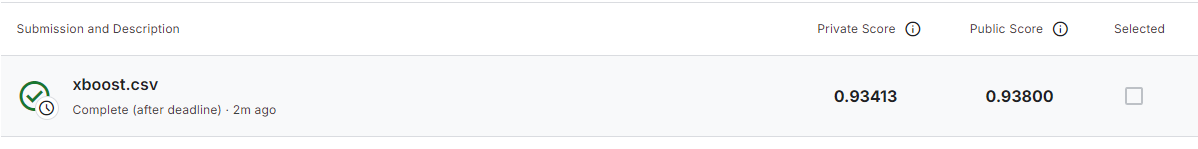

In [43]:
from IPython.display import Image
Image("screenshot.png")

This model is the best i built yet, i even tested it on test data:)

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [13]:
import lightgbm as lgb

cat_features = train_inputs.select_dtypes(include='object').columns
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

In [15]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(train_inputs, train_target, eval_set=[(val_inputs, val_target)])

train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

triain_proba = lgb_clf.predict_proba(train_inputs)
val_proba = lgb_clf.predict_proba(val_inputs)

print(classification_report(train_target, train_pred, digits=4))
print(classification_report(val_target, val_pred, digits=4))
print(roc_auc_score(train_target,triain_proba[:, -1]))
print(roc_auc_score(val_target,val_proba[:, -1]))


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=. Current value: categorical_feature=
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


This model performs kind of the same as XGBoost. This model is pretty good estimator, maybe a bit overfited. But aslo a good balance

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [12]:

def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_target, eval_set=[(val_inputs, val_target)])
    pred = clf.predict_proba(val_inputs)
    accuracy = roc_auc_score(val_target, pred[:, -1])

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(train_inputs, train_target, eval_set=[(val_inputs, val_target)])
final_pred = final_clf.predict_proba(val_inputs)
final_accuracy = roc_auc_score(val_target, final_pred[:, -1])

print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))

print(roc_auc_score(val_target, final_pred[:, -1]))


[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=. Current value: categorical_feature=
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warn

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warn

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warn

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] Stopped training because there are no more leaves

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] St

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")

c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
c:\ProgramData\anaconda3\Lib\site-packages\lightgbm\basic.py:2140: UserWarning: cat_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: missing
Точність на валідаційній вибірці: 0.9346
0.9346045682145552


This model is a bit worse than XGBoost Hyperopt, but still pretty good. 

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

All the models in this task are really good estimators and performed pretty good, especially with tuning. I allready uploaded the photo erlier so i think this task is done. 

I took XGBoost with hyperopt becaues it had the best result on validation data, and i think if it estimates unseen data so good, it should be aslo good at test data.